# Reinforcement Learning for Navigation Network Study

In [2]:
from torchsummary import summary

import numpy as np

import wandb
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchmetrics

In [3]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [4]:
import pathlib
last_treatment = ""
current_file_path = "C:/Users/batua/Desktop/RLNav/RLAgency/Notebooks/SupervisedGNN.ipynb" 
current_file_path

'C:/Users/batua/Desktop/RLNav/RLAgency/Notebooks/SupervisedGNN.ipynb'

In [5]:
import networkx as nx

import dgl
from dgl.nn import GraphConv
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

Using backend: pytorch


In [6]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The Incoming Data

In [7]:
import json
jsonstr = """{"SourceNodes":[0],"DestinationNodes":[1],"NumNodes":2,"Features":[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0]]}"""

observations = np.load('Data/DebugRandom.npy')
observations = observations.squeeze()
print("Loaded shape:", observations.shape)

Loaded shape: (10000, 505)


In [8]:
agent_pos = observations[:, 13:16]
goal_pos  = observations[:, 16:19]
RELATIVE_POS = goal_pos - agent_pos

In [9]:
GRAPH_FEATURE_SET = np.stack([agent_pos, goal_pos], axis=1)
print(GRAPH_FEATURE_SET.shape)

(10000, 2, 3)


In [10]:
jsonGraph = json.loads(jsonstr)

source_nodes = jsonGraph["SourceNodes"]
destination_nodes = jsonGraph["DestinationNodes"]
num_nodes = jsonGraph["NumNodes"]

GRAPH_SPECIFICATION = (source_nodes, destination_nodes)

Node 0: Agent
Node 1: Goal


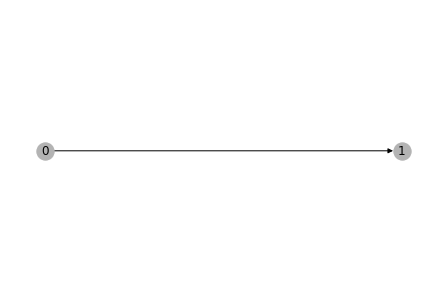

In [11]:
import json
def visualize_graph(g):
  nx_G = g.to_networkx()
  pos = nx.kamada_kawai_layout(nx_G)
  pos = nx.planar_layout(nx_G)
  nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

g = dgl.graph(GRAPH_SPECIFICATION, num_nodes=num_nodes)
visualize_graph(g)

print("Node 0: Agent")
print("Node 1: Goal")

In [12]:
from dgl.data import DGLDataset

class DebugAgentGoalPosDataset(DGLDataset):
  def __init__(self, specification, node_features_array, labels, edge_type="agent_to_goal", add_self_loops=True, add_node_id=True, gpu=True):
      self.device = "cuda:0" if gpu else "cpu"
      
      self.specification = specification
      self.node_features_array = node_features_array
      self.labels = th.tensor(labels, device=self.device)
      
      self.add_self_loops = add_self_loops
      self.edge_type = edge_type
      self.add_node_id = add_node_id
      
      super().__init__(name='DebugAgentGoalPosDataset')
        
  def process(self):
    self.graphs = []
    
    for graph_features in self.node_features_array:
      g = dgl.graph(self.specification)
      
      if self.add_self_loops:
        g = dgl.add_self_loop(g)
      
      if self.edge_type == "bi_directional":
        g = dgl.to_bidirected(g)
      elif self.edge_type == "goal_to_agent":
        g = dgl.reverse(g)
      elif self.edge_type == "agent_to_goal":
        pass
      else:
        assert False, f"{self.edge_type} is not a valid edge type!"
      
      if self.device == "cuda:0":
        g = g.to(self.device)
        
      if self.add_node_id:
        onehot_ids = np.identity(2)
        graph_features = np.concatenate([onehot_ids, graph_features], axis=1, dtype=np.float32)
        
      g.ndata["feat"] = th.tensor(graph_features, device=self.device)
      self.graphs.append(g)
      

  def __getitem__(self, i):
    return self.graphs[i], self.labels[i]

  def __len__(self):
    return len(self.graphs)

In [13]:
def create_dataloaders(edge_type, add_node_id=True, add_self_loops=True, batch_size=8, overfit_optimization=False, gpu=True):
  
  
  node_features_array = GRAPH_FEATURE_SET[:batch_size + 1] if overfit_optimization else GRAPH_FEATURE_SET 
  dataset = DebugAgentGoalPosDataset(specification=GRAPH_SPECIFICATION, 
                                     node_features_array=node_features_array, 
                                     labels=RELATIVE_POS,
                                     gpu=gpu,
                                     edge_type=edge_type, 
                                     add_node_id=add_node_id,
                                     add_self_loops=add_self_loops)

  num_examples = len(dataset)
  num_train = int(num_examples * 0.9)

  train_sampler = SubsetRandomSampler(th.arange(num_train),)
  test_sampler = SubsetRandomSampler(th.arange(num_train, num_examples))

  train_dataloader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
  test_dataloader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=batch_size)
  
  return train_dataloader, test_dataloader

In [14]:
class SingleLayerGCN(pl.LightningModule):
  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer
      
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    pred = self(x, x.ndata['feat'])
    loss = F.mse_loss(pred, y)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"loss":loss}

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch

    pred = self(x, x.ndata['feat'])
    loss = F.mse_loss(pred, y)

    self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"val_loss":loss}

  def train_dataloader(self):
      train_dataloader, _ = create_dataloaders(edge_type="goal_to_agent")
      return train_dataloader
  
  def get_agent_nodes(self, g, agent_index=0):
    """
      node_count:int the number of nodes in each of the graph. We assume this is the same.
      example agent_subgraph_idxs if we assume agent_index=0
      [ 0,  2,  4,  6,  8, 10, 12, 14] 
      https://docs.dgl.ai/generated/dgl.batch.html
    """
    batch_num_nodes = set(g.batch_num_nodes())
    assert len(batch_num_nodes) != 1, "The graphs in the batch have different number of nodes."
    
    node_count = batch_num_nodes.pop()
    agent_subgraph_idxs = th.arange(agent_index, node_count * g.batch_size, step=node_count, device=self.device)

    batched_agent_nodes = dgl.node_subgraph(g, agent_subgraph_idxs)
    return batched_agent_nodes
  
  def __init__(self, in_dim, h_feats=16, aggregation_method="node", residual=False, linear_output=False, linear_input=False, learning_rate=0.001):
    super(SingleLayerGCN, self).__init__()
    self.learning_rate = learning_rate
    self.aggregation_method = aggregation_method
    self.residual = residual
    self.conv1 = GraphConv(in_dim, 3, allow_zero_in_degree=True)
  
  def forward(self, g, x):
    if self.residual:
      x += self.conv1(g, x)
    else:
      x = self.conv1(g, x)
      
    g.ndata["hidden"] = x
    agent_nodes = self.get_agent_nodes(g, 0)
    x = agent_nodes.ndata["hidden"]    
    return x

In [15]:
class AggregateGCN(pl.LightningModule):
  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer
      
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    pred = self(x, x.ndata['feat'])
    loss = F.mse_loss(pred, y)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"loss":loss}

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch

    pred = self(x, x.ndata['feat'])
    loss = F.mse_loss(pred, y)

    self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"val_loss":loss}

  def train_dataloader(self):
      train_dataloader, _ = create_dataloaders(edge_type="goal_to_agent")
      return train_dataloader
  
  def get_agent_nodes(self, g, agent_index=0):
    """
      node_count:int the number of nodes in each of the graph. We assume this is the same.
      example agent_subgraph_idxs if we assume agent_index=0
      [ 0,  2,  4,  6,  8, 10, 12, 14] 
      https://docs.dgl.ai/generated/dgl.batch.html
    """
    batch_num_nodes = set(g.batch_num_nodes())
    assert len(batch_num_nodes) != 1, "The graphs in the batch have different number of nodes."
    
    node_count = batch_num_nodes.pop()
    agent_subgraph_idxs = th.arange(agent_index, node_count * g.batch_size, step=node_count, device=self.device)

    batched_agent_nodes = dgl.node_subgraph(g, agent_subgraph_idxs)
    return batched_agent_nodes
  
  def __init__(self, in_dim, h_feats=16, num_layers=3, aggregation_method="node", residual=False, linear_output=False, linear_input=False, learning_rate=0.001):
    super(AggregateGCN, self).__init__()
    self.learning_rate = learning_rate
    self.aggregation_method = aggregation_method
    self.linear_output=linear_output
    self.linear_input=linear_input
    self.residual = residual
    if residual and not (linear_input and linear_output):
      raise Exception("When residual, linear_input and linear_output need to be True.")
    
    if self.linear_input:
      self.linear_in = nn.Linear(in_dim, h_feats)
      self.conv1 = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)
    else:
      self.conv1 = GraphConv(in_dim, h_feats, allow_zero_in_degree=True)
      
    self.conv2 = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)
    
    if not self.linear_output:
      self.conv3 = GraphConv(h_feats, 3, allow_zero_in_degree=True)
    else:
      self.conv3 = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)
      self.linear_out1 = nn.Linear(h_feats, 3)
      self.linear_out2 = nn.Linear(3, 3)
  
  def forward(self, g, x):
    if self.linear_input:
      x = F.relu(self.linear_in(x))
      
    if not self.residual:
      x = F.relu(self.conv1(g, x))
      x = F.relu(self.conv2(g, x))
      x = F.relu(self.conv3(g, x))
    else:
      x += F.relu(self.conv1(g, x))
      x += F.relu(self.conv2(g, x))
      x += F.relu(self.conv3(g, x))

    g.ndata["hidden"] = x
    agent_nodes = self.get_agent_nodes(g, 0)
    x = agent_nodes.ndata["hidden"]    
          
    if self.linear_output:
      x = F.relu(self.linear_out1(x)) # non_linearity
      x = self.linear_out2(x) # can't have activation 
    return x

In [24]:
class GCNLayer(pl.LightningModule):
  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer
      
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    pred = self(x, x.ndata['feat'])
    loss = F.mse_loss(pred, y)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"loss":loss}

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch

    pred = self(x, x.ndata['feat'])
    loss = F.mse_loss(pred, y)

    self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return {"val_loss":loss}

  def train_dataloader(self):
      train_dataloader, _ = create_dataloaders(edge_type="goal_to_agent")
      return train_dataloader
  
  def get_agent_nodes(self, g, agent_index=0):
    """
      node_count:int the number of nodes in each of the graph. We assume this is the same.
      example agent_subgraph_idxs if we assume agent_index=0
      [ 0,  2,  4,  6,  8, 10, 12, 14] 
      https://docs.dgl.ai/generated/dgl.batch.html
    """
    batch_num_nodes = set(g.batch_num_nodes())
    assert len(batch_num_nodes) != 1, "The graphs in the batch have different number of nodes."
    
    node_count = batch_num_nodes.pop()
    agent_subgraph_idxs = th.arange(agent_index, node_count * g.batch_size, step=node_count, device=self.device)

    batched_agent_nodes = dgl.node_subgraph(g, agent_subgraph_idxs)
    return batched_agent_nodes
  
  def __init__(self, in_dim, h_feats=16, num_layers=3, aggregation_method="node", residual=False, linear_output=False, linear_input=False, learning_rate=0.001):
    super(GCNLayer, self).__init__()
    self.learning_rate = learning_rate
    self.aggregation_method = aggregation_method
    self.linear_output=linear_output
    self.linear_input=linear_input
    self.residual = residual
    self.num_layers = num_layers
    
    if residual and not (linear_input and linear_output):
      raise Exception("When residual, linear_input and linear_output need to be True.")
    
    self.linear_in = nn.Linear(in_dim, h_feats)
    self.convs = nn.ModuleList([GraphConv(h_feats, h_feats, allow_zero_in_degree=True) 
                                for _ in range(self.num_layers)])
    self.one_conv = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)
    self.linear_out1 = nn.Linear(h_feats, 3)
    self.linear_out2 = nn.Linear(3, 3)
  
  def forward(self, g, x):
    x = F.relu(self.linear_in(x))

    for layer in self.convs:
      x = x + F.relu(layer(g, x)) if self.residual else F.relu(layer(g, x))

    g.ndata["hidden"] = x
    agent_nodes = self.get_agent_nodes(g, 0)
    
    
    x = agent_nodes.ndata["hidden"]    
    x = F.relu(self.linear_out1(x)) # non_linearity
    x = self.linear_out2(x) # can't have activation 
    return x

In [17]:
start_over = True
if start_over:
  train_dataloader, _ = create_dataloaders(edge_type="goal_to_agent", add_self_loops=False, overfit_optimization=True, gpu=False)
  overfit_graph, overfit_label = next(iter(train_dataloader))  

  model = GCNLayer(5, num_layers=3, linear_input=True, linear_output=True, residual=True)
  optimizer = optim.Adam(model.parameters(), lr=0.025)

for i in range(0, 1001):
  pred = model(overfit_graph, overfit_graph.ndata['feat'])
  loss = F.mse_loss(pred, overfit_label)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if i % 100 == 0:
    print(f"Loss is {loss.item():.1e} at step {i}")


Loss is 1.7e-01 at step 0
Loss is 8.6e-03 at step 100
Loss is 8.6e-03 at step 200
Loss is 8.5e-03 at step 300
Loss is 8.5e-03 at step 400
Loss is 8.5e-03 at step 500
Loss is 8.5e-03 at step 600
Loss is 8.5e-03 at step 700
Loss is 4.3e-03 at step 800
Loss is 3.8e-03 at step 900
Loss is 3.8e-03 at step 1000


In [18]:
def run_overfit_sweep():
  experiment_name = "Overfitting_ID_WeightStudy"
  hyperparams_1 = [1, 2, 4, 7, 8, 16, 32, 256]

  for _ in range(3):
    for hdim in hyperparams_1:
      treatment_name = f"GoalToAgent_Hdim{hdim}"
      train_dataloader, _ = create_dataloaders(edge_type="goal_to_agent", overfit_optimization=True, gpu=False)
      overfit_graph, overfit_label = next(iter(train_dataloader))  
      overfit_graph.ndata["feat"] = th.tensor([[i,i,i] for i in range(-4, 4) for _ in range(2)])/4

      config = {
        "edge_type":"goal_to_agent",
        "self_loop":True,
        "treatment_name": treatment_name,
        "hidden_dim": hdim
      }

      run = wandb.init(project="GNN_Supervised", group=experiment_name, name=treatment_name, config=config, save_code=True)  
      model = AggregateGCN(3, hdim)
      optimizer = optim.Adam(model.parameters(), lr=0.01)

      for i in range(0, 1501):
        pred = model(overfit_graph, overfit_graph.ndata['feat'])
        loss = F.mse_loss(pred, overfit_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
          print(f"Loss is {loss.item():.1e} at step {i}")
          wandb.log({"loss":loss})
      wandb.finish()


# Fulldataset Experiments

In [19]:
def find_lr():
  train_dl, test_dl = create_dataloaders(edge_type="goal_to_agent")
  model = AggregateGCN(3, h_feats=16)
  trainer = pl.Trainer(gpus=1)

  # Run learning rate finder
  lr_finder = trainer.tuner.lr_find(model)

  # Results can be found in
  lr_finder.results

  # Plot with
  fig = lr_finder.plot(suggest=True)
  fig.show()

  # Pick point based on plot, or get suggestion
  new_lr = lr_finder.suggestion()
# find_lr()

In [23]:
def grid_visualization(model, config, _1d=False, log_wandb=False):
  goaly = 0.0141843995
  ranges = 2
  size = .5 * ranges
  x_poss = np.arange(-0.35 * ranges, 0.3501 * ranges, step=0.1)
  z_poss = np.arange(-0.35 * ranges, 0.3501 * ranges, step=0.1)
  if _1d:
    z_poss = [0]

  grid_graph_featureset = []
  labels = []
  xy_poss = []
  for x in x_poss:
    for z in z_poss:
      agent = np.array([0, 0.02, 0])
      goal = np.array([x, goaly, z])
      labels.append(goal-agent)
      graph_feat = np.stack([agent, goal])
      grid_graph_featureset.append(graph_feat)
      xy_poss.append([x,z])

  ds = DebugAgentGoalPosDataset(specification=GRAPH_SPECIFICATION, 
                               node_features_array=grid_graph_featureset, 
                               labels=labels,
                               gpu=False,
                               edge_type= config["edge_type"], 
                               add_node_id=config["node_id"],
                               add_self_loops=config["self_loop"])
  xs, ys = ds[:]
  x_batch = dgl.batch(xs)
  x_batch.ndata["feat"] = x_batch.ndata["feat"].float()
  res = model(x_batch, x_batch.ndata["feat"]).detach().numpy()
  res_xz = np.stack([res[:,0], res[:,2]],axis=1)

  pos_x = pos_y = np.zeros(len(res_xz))
  dir_x, dir_y = list(zip(*res_xz))

  f, axs = plt.subplots(1,2, figsize=(14, 7))
  x_poss, z_poss = list(zip(*xy_poss))
  axs[0].scatter(x_poss, z_poss, marker=".", linewidths=0.1)
  axs[0].set_xlim([-size, size])
  axs[0].set_ylim([-size, size])

  axs[1].quiver(pos_x, pos_y, dir_x, dir_y, scale=1)
  axs[1].set_xlim([-size, size])
  axs[1].set_ylim([-size, size])
  if log_wandb:
    wandb.log({"grid_plot":wandb.Image(f)})

In [ ]:
wandb.finish()
experiment_name = "OneTrainable"
config = {
  "edge_type": "goal_to_agent",
  "self_loop": True,
  "hidden_dim": 16,
  "learning_rate":0.001,
  "node_id":True,
  "input_dim":5,
  "linear_output":True,
  "linear_input":True,
  "residual":True,
  "aggregation_method":"node",
  "batch_size":64,
  "model_type":GCNLayer,#AggregateGCN,#  ##SingleLayerGCN 
  "num_layers":3,
  "activation":"relu"
}

hyperparams_1 = ["goal_to_agent"]
hyperparams_2 = [True]
hyperparams_3 = [1,2,3,4,5,6]

for _ in range(3):
  for edge_type in hyperparams_1:
    for residual in hyperparams_2:
      for num_layers in hyperparams_3:
        config["edge_type"] = edge_type 
        config["residual"] = residual 
        config["num_layers"] = num_layers 

        treatment_name = f"GConv Application Count: {num_layers}"

        run = wandb.init(project="GNN_Supervised", group=experiment_name, name=treatment_name, config=config, save_code=True)  
        wandb_logger = WandbLogger()

        train_dataloader, val_dataloader = create_dataloaders(edge_type=config["edge_type"], 
                                                            add_self_loops=config["self_loop"], 
                                                            add_node_id=config["node_id"],
                                                            batch_size=config["batch_size"],
                                                            gpu=True)

        trainer = pl.Trainer(gpus=1, max_epochs=20, logger=wandb_logger)
        GNN = config["model_type"]
        model = GNN(config["input_dim"],
                   config["hidden_dim"],
                   aggregation_method=config["aggregation_method"],
                   linear_input=config["linear_input"],
                   linear_output=config["linear_output"],
                   residual=config["residual"],
                   learning_rate=config["learning_rate"],
                   num_layers=config["num_layers"])

        trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)      
  #       grid_visualization(model, config, False, log_wandb=True)
  #       grid_visualization(model, config, True, log_wandb=True)
        wandb.finish()


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,██▄▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss_epoch,0.00017
train_loss_step,0.00015
trainer/global_step,2819
val_loss_epoch,0.00015


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▅▅▃▂▃▂▁▃▂▃▃▃▃▂▃▂▅▃▂▃▂▃▃▂▄▃▂▃▄▃▃▂▂▃▁▁▂▂
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_loss_step,█▇▅▄▅▄▂▃▅▄▄▃▃▄▄▄▆▄▅▄▃▅▄▁▄▂▅▃▅▄▂▄▃▆▃▁▁▃▅▃
epoch,19
train_loss_epoch,0.0246
train_loss_step,0.02348
trainer/global_step,2819
val_loss_epoch,0.03193


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▄▄▃▃▂▂▁▂▁▂▁▂▁▂▁▂▂▁▁▂▁▂▁▂▂▂▁▂▁▂▂▂▂▁▂▂▂▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,▇█▄▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▁▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂
epoch,19
train_loss_epoch,0.04842
train_loss_step,0.04635
trainer/global_step,2819
val_loss_epoch,0.05704


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,██▃▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss_epoch,7e-05
train_loss_step,5e-05
trainer/global_step,2819
val_loss_epoch,0.00021


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▅▄▃▂▂▃▂▁▂▂▁▃▂▂▂▂▁▂▃▃▂▃▂▁▂▂▂▁▂▂▂▃▂▂▂▂▂▂
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,█▆▂▃▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▂▂▃▂▂▁▂▂▂▂▁▂▂▂▁▁▂▂▂▂▃
epoch,19
train_loss_epoch,0.04844
train_loss_step,0.05092
trainer/global_step,2819
val_loss_epoch,0.05734


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,██▅▄▃▃▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
epoch,19
train_loss_epoch,0.02193
train_loss_step,0.02608
trainer/global_step,2819
val_loss_epoch,0.02399


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▃▃▃▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▆▅▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,▇█▆▇▄▅▄▄▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss_epoch,0.00021
train_loss_step,0.00021
trainer/global_step,2819
val_loss_epoch,0.00016


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▅▄▃▂▂▂▁▁▁▂▁▂▁▁▂▁▁▂▁▁▁▂▁▂▂▂▂▁▂▁▂▂▁▁▁▂▂▂
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,█▇▅▅▂▃▃▃▂▂▂▁▂▁▃▂▂▁▂▂▁▂▁▁▂▃▂▂▂▂▂▂▃▂▁▂▂▂▃▂
epoch,19
train_loss_epoch,0.04845
train_loss_step,0.05056
trainer/global_step,2819
val_loss_epoch,0.05724


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,██▅▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss_epoch,0.00017
train_loss_step,0.00013
trainer/global_step,2819
val_loss_epoch,0.00021


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▆▄▃▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,█▆▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss_epoch,0.0003
train_loss_step,0.00021
trainer/global_step,2819
val_loss_epoch,0.0002


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▅▃▂▂▂▃▂▃▂▂▂▂▂▃▁▃▂▂▂▂▁▁▂▂▂▂▁▂▃▁▂▂▂▂▂▃▁▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,█▇▂▅▃▃▂▂▁▃▃▁▄▂▃▃▂▃▃▃▁▃▂▂▂▃▂▂▂▂▂▃▃▂▂▃▁▃▃▃
epoch,19
train_loss_epoch,0.04843
train_loss_step,0.04332
trainer/global_step,2819
val_loss_epoch,0.05726


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▅▄▃▂▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁
trainer/global_step,▁▁▁▁▂▁▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▇▂▂▂▂▂█
val_loss_epoch,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,▇█▄▅▂▄▃▂▂▁▃▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▂▃▁▃▂▂▂▂▂▂▂▂▁
epoch,19
train_loss_epoch,0.04843
train_loss_step,0.04501
trainer/global_step,2819
val_loss_epoch,0.05701


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | linear_in   | Linear    | 96    
1 | one_conv    | GraphConv | 272   
2 | linear_out1 | Linear    | 51    
3 | linear_out2 | Linear    | 12    
------------------------------------------
431       Trainable params
0         Non-trainable params
431       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
import pandas as pd

def analyse_model(trained_model, data_loader):
  def visualize_predictions(vis_df):
    fig, axs = plt.subplots(2, 2)

    agent_idx, goal_idx = 0, 1
    xpos_idx, zpos_idx  = 2-2, 4-2

    for i, ax in enumerate(axs.flat):
      vis_x = [vis_df["x"].iloc[i][agent_idx][xpos_idx], vis_df["x"].iloc[i][goal_idx][xpos_idx]]
      vis_y = [vis_df["x"].iloc[i][agent_idx][zpos_idx], vis_df["x"].iloc[i][goal_idx][zpos_idx]]
      ax.scatter(vis_x[0:1], vis_y[0:1], color="orange")
      ax.scatter(vis_x[1:], vis_y[1:], color="cyan")

      q_x = [df["pred"].iloc[i][0]]
      q_y = [df["pred"].iloc[i][2]]
      ax.quiver(vis_x[0:1], vis_y[0:1], q_x, q_y, scale=1)

      ax.set_xlim([-1, 1])
      ax.set_ylim([-1, 1])
      
  xgraph, y = next(iter(data_loader))
  xgraph = xgraph.to("cpu")
  y = y.to("cpu")
  trained_model = trained_model.to("cpu")

  pred = trained_model(xgraph, xgraph.ndata["feat"])
  x = xgraph.ndata["feat"].reshape(-1, 2, 3)
  element_wise_loss = F.mse_loss(pred, y, reduction="none").detach().numpy()
  vector_loss = np.sum(element_wise_loss, axis=1)

  y = y.detach().numpy()
  x = x.detach().numpy()
  pred = pred.detach().numpy()  

  df = pd.DataFrame({
    "x":list(x),
    "y":list(y),
    "pred":list(pred),
    "element_wise_loss":list(element_wise_loss),
    "vector_loss":list(vector_loss)
    })
  
  print(f"Pred Max: {np.max(pred)}")
  print(f"Pred Min: {np.min(pred)}")  
  print(f"Pred STD: {np.std(pred)}")  
  
  df.sort_values(by=['vector_loss'], ascending=False, inplace=True)
  df.plot.bar(y="vector_loss")
  
  top_loss = df.iloc[:4]
  min_loss = df.iloc[-4:]
  
  visualize_predictions(top_loss)
  visualize_predictions(min_loss)

Pred Max: 0.4726664125919342
Pred Min: -0.6296812295913696
Pred STD: 0.19145120680332184


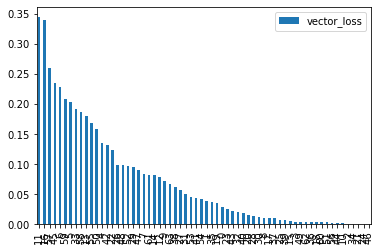

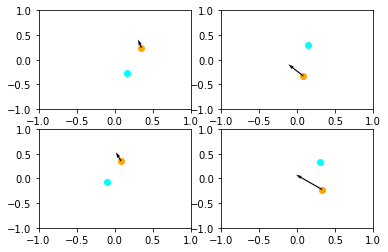

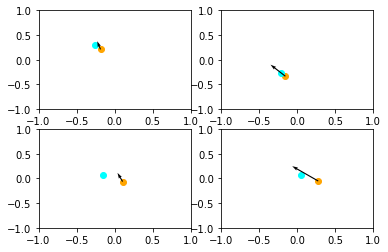

In [25]:
analyse_model(model, val_dataloader)

In [ ]:
analyse_model(model, train_dataloader)